In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

data = pd.read_csv('content/train_labels.csv')
train_path = 'content/train/'
test_path = 'content/test/'
# quick look at the label stats
data['label'].value_counts()
print(type(data['label'][0]))

<class 'numpy.int64'>


content/train/00c09692dff276f33c9e18dfeaefa02db93f5a44.tif
content/train/00d2dad6969cf1524fa28f98d7d90bf4db39304f.tif
content/train/0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif
content/train/00dea83eb4b643ee12912311ddda8d6fdd71e0bd.tif
content/train/00ca76c8ed6939a888b54674ec6b6649e5114784.tif
content/train/00f9d923b993fb4975fe00c469a1adbb91850095.tif
content/train/0a3ea8584dcb590be979bb0b5397132592a2544f.tif
content/train/00b5c89eb11671f8e38ee99830329b133b396651.tif
content/train/00c97a30ee0952ee449061a4aa8f8bf482fece61.tif
content/train/00b7a94a9efaf5d1e3902c80f3000a3156692ebf.tif


Text(0, 0.5, 'Tumor tissue samples')

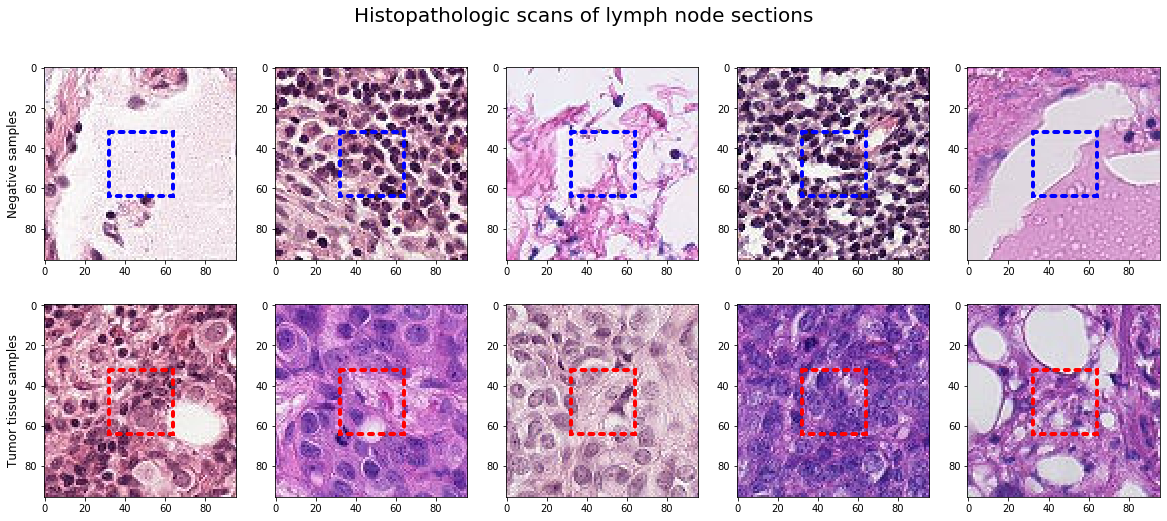

In [2]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    print(path)
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

# random sampling
shuffled_data = shuffle(data)

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Tumor tissue samples', size='large')


In [3]:
##### Essai pour explorer les données
print(i,idx)
print(readImage(path + '.tif').shape)
print(readImage(path + '.tif')[0,2,:])
myCmd = 'du '+ path + '.tif'
#myCmd = os.popen('ls -la').read()
#myCmd2="ls"
#os.system(myCmd)
#os.system(myCmd2)
import subprocess
#subprocess.run(["ls", "-l", "/dev/null"])# ,shell=True, check=True) # , capture_output=True)
#subprocess.call("ls")
#subprocess.call(["ls", "-l", "."])
"""MyOut = subprocess.Popen(['du', "."], 
            stdout=subprocess.PIPE, 
            stderr=subprocess.STDOUT)
stdout,stderr = MyOut.communicate()
print("stdout",stdout)
print("stderr",stderr)"""

4 00b7a94a9efaf5d1e3902c80f3000a3156692ebf
content/train/00b7a94a9efaf5d1e3902c80f3000a3156692ebf.tif
(96, 96, 3)
content/train/00b7a94a9efaf5d1e3902c80f3000a3156692ebf.tif
[206 146 220]


'MyOut = subprocess.Popen([\'du\', "."], \n            stdout=subprocess.PIPE, \n            stderr=subprocess.STDOUT)\nstdout,stderr = MyOut.communicate()\nprint("stdout",stdout)\nprint("stderr",stderr)'

In [4]:
import random
ORIGINAL_SIZE = 96      # original size of the images - do not change

# AUGMENTATION VARIABLES
CROP_SIZE = 90          # final size after crop
RANDOM_ROTATION = 3    # range (0-180), 180 allows all rotation variations, 0=no change
RANDOM_SHIFT = 2        # center crop shift in x and y axes, 0=no change. This cannot be more than (ORIGINAL_SIZE - CROP_SIZE)//2 
RANDOM_BRIGHTNESS = 7  # range (0-100), 0=no change
RANDOM_CONTRAST = 5    # range (0-100), 0=no change
RANDOM_90_DEG_TURN = 1  # 0 or 1= random turn to left or right

def readCroppedImage(path, augmentations = True):
    # augmentations parameter is included for counting statistics from images, where we don't want augmentations
    
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    
    if(not augmentations):
        return rgb_img / 255
    
    #random rotation
    rotation = random.randint(-RANDOM_ROTATION,RANDOM_ROTATION)
    if(RANDOM_90_DEG_TURN == 1):
        rotation += random.randint(-1,1) * 90
    M = cv2.getRotationMatrix2D((48,48),rotation,1)   # the center point is the rotation anchor
    rgb_img = cv2.warpAffine(rgb_img,M,(96,96))
    
    #random x,y-shift
    x = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    y = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    
    # crop to center and normalize to 0-1 range
    start_crop = (ORIGINAL_SIZE - CROP_SIZE) // 2
    end_crop = start_crop + CROP_SIZE
    rgb_img = rgb_img[(start_crop + x):(end_crop + x), (start_crop + y):(end_crop + y)] / 255
    
    # Random flip
    flip_hor = bool(random.getrandbits(1))
    flip_ver = bool(random.getrandbits(1))
    if(flip_hor):
        rgb_img = rgb_img[:, ::-1]
    if(flip_ver):
        rgb_img = rgb_img[::-1, :]
        
    # Random brightness
    br = random.randint(-RANDOM_BRIGHTNESS, RANDOM_BRIGHTNESS) / 100.
    rgb_img = rgb_img + br
    
    # Random contrast
    cr = 1.0 + random.randint(-RANDOM_CONTRAST, RANDOM_CONTRAST) / 100.
    rgb_img = rgb_img * cr
    
    # clip values to 0-1 range
    rgb_img = np.clip(rgb_img, 0, 1.0)
    
    return rgb_img

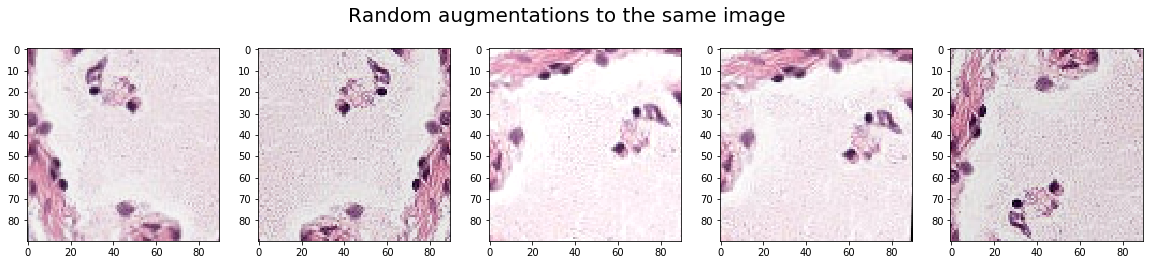

In [5]:
fig, ax = plt.subplots(1,5, figsize=(20,4))
fig.suptitle('Random augmentations to the same image',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:1]):
    for j in range(5):
        path = os.path.join(train_path, idx)
        ax[j].imshow(readCroppedImage(path + '.tif'))